In [195]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from matplotlib import pyplot as plt

import optuna as opt
from optuna.trial import TrialState

from typing import Callable
from typing import Iterable
import re
import json
from sklearn.model_selection import train_test_split

np.set_printoptions(suppress=True, precision=3, threshold=np.inf)

# choose dataset to train
ds_num = 1

dataset_info = {
    1: ('mtb_num', 8),
    2: ('road_num', 6),
    3: ('mtb_one_hot', 53),
    4: ('road_one_hot', 50)
}

DS, INPUT_FEATURES = dataset_info[ds_num]

# choose strategy for optuna optimizer, should it maximize accurancy or minimize loss
# 1 - accurancy
# 2 - loss

opt_num = 2

opt_info = {
    1: ('maximize', 'accurancy'),
    2: ('minimize', 'loss')
}

STUDY_DIRECTION,  STRATEGY = opt_info[opt_num]

In [196]:
''' code in this cell is done apart from train_rate function, to save some time while looking for best hyperparams with optuna
    X, Y, X_test, Y_test - global variables '''

dataset = pd.read_csv('data\\' + DS + '.csv', delimiter=',')
    
# seperate labels (price) and data
x = dataset.drop(columns=['Price', 'ID']).astype(float)
y = dataset['Price']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# conversion from data frame do numpy matrix
x_train, x_test, y_train, y_test = map(lambda x: x.to_numpy(), [x_train, x_test, y_train, y_test])

# change of y shape from (n,) to (n,-1)
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

# index removal (left from DF)
x_train = x_train[:,1:]
x_test = x_test[:,1:]

# conversion to tensors
X, Y, X_test, Y_test = map(lambda x: torch.tensor(x, dtype=torch.float32), [x_train, y_train, x_test, y_test]) 

In [197]:
def train_and_rate(trial: opt.trial.Trial, model: nn.Sequential, optimizer: optim, loss_fn: Callable, mb_size, epochs,
                   X = X, Y = Y, X_test = X_test, Y_test = Y_test):  
    
    # loss per epoch
    lpe = np.zeros(epochs)

    # proper training of nn 
    for j,epoch in enumerate(range(epochs)):
        avg_epoch_loss = 0
        for i in range(0, len(X), mb_size):
            Xbatch = X[i:i+mb_size]  
            
            # compute loss
            y_pred = model(Xbatch)
            y_batch = Y[i:i+mb_size]
            loss = loss_fn(y_pred, y_batch)
            avg_epoch_loss += loss.item() * Xbatch.size(0) # mulitply by Xbatch.size(0), because last batch can have diffrent size, so we scale loss by batch sizes 

            optimizer.zero_grad() # set grads to 0
            loss.backward()       # backprop
            optimizer.step()      # update params with optimazation 
        
        # compute lpe
        avg_epoch_loss /= len(X)  
        lpe[j] = avg_epoch_loss

        # predict prices
        with torch.no_grad():
            y_pred = model(X).detach().numpy()
            y_pred_test = model(X_test).detach().numpy()

        accurancy = (abs(y_pred_test - Y_test.numpy()) < 100).mean()

        score = avg_epoch_loss if STRATEGY == 'loss' else accurancy 

        # if trainig goes wrong optuna will prune the process
        trial.report(score, epoch)
        if trial.should_prune():
            raise opt.exceptions.TrialPruned() 
    
    # also return loss from every epoch (lpe) to plot the training process in the raport
    return score, lpe 


In [198]:
def define_model(trial):
    n_layers = trial.suggest_int("n_layers", 1, 5)
    layers = []

    in_features = INPUT_FEATURES
    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), 4, 16)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        p = trial.suggest_float("dropout_l{}".format(i), 0.1, 0.5)
        layers.append(nn.Dropout(p))

        in_features = out_features
    layers.append(nn.Linear(in_features, 1))

    return nn.Sequential(*layers)

In [199]:
#RMSE
def loss_fn(y_pred, y):
    loss = 0
    for y1, y2 in zip(y_pred, y):
        loss += pow(abs(y1-y2),2)
    return torch.sqrt(loss/len(y))

In [200]:
models = []
lpes = []
def objective(trial):
    model = define_model(trial)
    models.append(model)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    lr = trial.suggest_float('learning_rate', 1e-5, 1e-1)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    mb_size = trial.suggest_int('mini_batch_size', 8, 64) 
    epo = trial.suggest_int('epochs', 10, 30)
    
    lpes.append(0) # in case learining will be pruned
    score, lpe = train_and_rate(trial = trial, model = model, optimizer = optimizer, loss_fn = loss_fn, mb_size = mb_size, epochs = epo)
    lpes[-1] = lpe
    
    return score


In [201]:
study = opt.create_study(sampler=opt.samplers.TPESampler(), direction=STUDY_DIRECTION)
study.optimize(objective, n_trials=300)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-03-04 13:25:38,079] A new study created in memory with name: no-name-015b15d6-19a9-476b-8d0f-08dc066ddab1
[I 2024-03-04 13:25:41,553] Trial 0 finished with value: 2186.774666419396 and parameters: {'n_layers': 1, 'n_units_l0': 13, 'dropout_l0': 0.4841656551989352, 'optimizer': 'Adam', 'lr': 0.009291994928445393, 'mini_batch_size': 15, 'epochs': 14}. Best is trial 0 with value: 2186.774666419396.
[I 2024-03-04 13:25:44,648] Trial 1 finished with value: 1829.4535700871395 and parameters: {'n_layers': 3, 'n_units_l0': 6, 'dropout_l0': 0.18806449309728537, 'n_units_l1': 8, 'dropout_l1': 0.42744478533057595, 'n_units_l2': 6, 'dropout_l2': 0.22171159030296753, 'optimizer': 'RMSprop', 'lr': 0.031415745243722315, 'mini_batch_size': 16, 'epochs': 12}. Best is trial 1 with value: 1829.4535700871395.
[I 2024-03-04 13:25:50,629] Trial 2 finished with value: 1535.4700099847255 and parameters: {'n_layers': 1, 'n_units_l0': 11, 'dropout_l0': 0.46082755571496326, 'optimizer': 'RMSprop', 'lr': 

Study statistics: 
  Number of finished trials:  300
  Number of pruned trials:  167
  Number of complete trials:  133
Best trial:
  Value:  1247.4877673222468
  Params: 
    n_layers: 2
    n_units_l0: 13
    dropout_l0: 0.12386304092066869
    n_units_l1: 16
    dropout_l1: 0.10016765328483607
    optimizer: RMSprop
    lr: 0.056265988439971576
    mini_batch_size: 9
    epochs: 16


{'n_layers': 2, 'n_units_l0': 13, 'dropout_l0': 0.12, 'n_units_l1': 16, 'dropout_l1': 0.1, 'optimizer': 'RMSprop', 'lr': 0.06, 'mini_batch_size': 9, 'epochs': 16}


KeyError: 'mb_size'

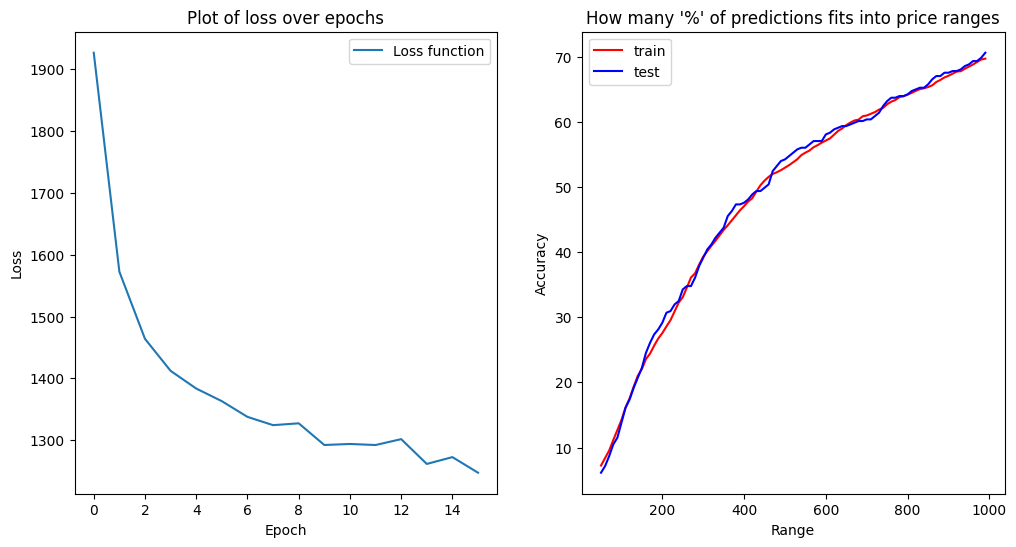

In [205]:
def generate_raport(best_trial = study.best_trial, catalog_path = 'best_models/' + DS, X = X, Y = Y, X_test = X_test, y_test = y_test):
    # get best params, model from best trial
    best_trial_params = best_trial.params
    best_model = models[best_trial.number] 

    # save model and params
    torch.save(best_model, catalog_path + '/best_' + DS + '_' + STRATEGY + '.pt')
    with open(catalog_path + '/best_params_' + DS + '_' + STRATEGY + '.json', 'w') as f:
        json.dump(best_trial_params, f, indent=4)

    # predict prices
    with torch.no_grad():
        y_pred = best_model(X).detach().numpy()
        y_pred_test = best_model(X_test).detach().numpy()

    # compute accurancy on train and test set
    accuracy_train_df = pd.Series([(abs(y_pred.round() - y_train) < i).mean() * 100 for i in range(50, 1000, 10)])
    accuracy_test_df = pd.Series([(abs(y_pred_test.round() - y_test) < i).mean() * 100 for i in range(50, 1000, 10)])
    
    # generate plots, which describe:  
    fig, (loss, acc) = plt.subplots(1, 2, figsize=(12,6))
    
    # loss per every epoch
    loss.plot(np.arange(best_trial_params['epochs']), lpes[best_trial.number], label="Loss function")
    loss.set_xlabel("Epoch")
    loss.set_ylabel("Loss")
    loss.set_title("Plot of loss over epochs")
    loss.legend()
    
    # accurancy in diffrent ranges
    acc.plot(range(50, 1000, 10), accuracy_train_df, c='r', label = 'train')
    acc.plot(range(50, 1000, 10), accuracy_test_df, c='b', label = 'test')
    acc.set_xlabel('Range')
    acc.set_ylabel('Accuracy')
    acc.set_title("How many '%' of predictions fits into price ranges")
    acc.legend()
     
    fig.savefig(catalog_path + '/plot_'+ DS + '_' + STRATEGY + '.jpg')

    # generate html with raport
    n_lay = best_trial_params['n_layers']
    th_model = ''.join(["<th>n units l{}</th><th>dropout l{}</th>".format(n, n) for n in range(n_lay)])
    td_model = ''.join([f"<td>{{n_units_l{n}}}</td><td>{{dropout_l{n}}}</td>" for n in range(n_lay)])

    best_trial_params_rounded = {k: round(v, 2) if isinstance(v, (float)) else v for k, v in best_trial_params.items()}
    print(best_trial_params_rounded) 
    html_raport_dict = best_trial_params_rounded | {'plot': 'plot_'+ DS + '_' + STRATEGY + '.jpg'} | {'td_model': td_model}| {'th_model': th_model} 
    html = '''
            <table border="1">
                
                <thead>
                    <tr style="text-align: center;">
                        <th colspan="100%">Hyperparameters</th>
                    </tr>
                    <tr style="text-align: center;">
                        <th>optimizer</th>
                        <th>lr</th>
                        <th>mb_size</th>
                        <th>epo</th>
                    </tr>
                </thead>
                <tbody>
                    <tr>
                        <td>{optimizer}</td>
                        <td>{learning_rate}</td>
                        <td>{mini_batch_size}</td>
                        <td>{epochs}</td>
                </tbody>

                <thead>
                    <tr style="text-align: center;">
                        <th colspan="100%">Model - every model has structure: Linear -> ReLu -> Linear ...</th>
                    </tr>
                    <tr style="text-align: center;">
                        <th>n_layers</th>
                        {th_model}
                    </tr>
                </thead>
                <tbody>
                    <tr>
                        <td>{n_layers}</td>
                        {td_model}
                    </tr>
                        <tr>
                        <td colspan = "100%">
                            <img src={plot}>
                        </td>
                    </tr>
                </tbody>
                </table>'''
    

    styles = '''
        <style>
        table{
            font-family: Arial, Helvetica, sans-serif;
            border-collapse: collapse;
            width: 100%;
        }
        
        table tbody td, table th {
            border: 1px solid #ddd;
            padding: 8px;
            text-align: center;
        }

        table tr:nth-child(even){
            background-color: #f2f2f2;
            text-align: center;
        }

        table tr:hover {background-color: #ddd;}

        table th {
            padding-top: 12px;
            padding-bottom: 12px;
            text-align: center;
            color: white;
        }

        table thead tr:nth-child(1) {
            font-size: 24px;
            background-color: #80b3ff;
        }

        table thead tr:nth-child(2) {
            background-color: #ff8080;
        }
    </style>
    '''
    html = html.format_map(html_raport_dict).format_map(html_raport_dict)

    print(html_raport_dict)
    with open(catalog_path + '/raport_' + DS + '_' + STRATEGY + '.html', 'w') as f:
        f.write(styles + html)

generate_raport()